In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import cv2
import mmdet
from mmdet.apis import init_detector, inference_detector
from mmdet.datasets import replace_ImageToTensor, build_dataset, build_dataloader
from mmdet.datasets.pipelines import Compose
from mmdet.core import bbox_cxcywh_to_xyxy, bbox_xyxy_to_cxcywh, bbox_xyxy_to_cxcywh
from tqdm import tqdm
import pickle
from mmdet.core.bbox.iou_calculators.iou2d_calculator import BboxOverlaps2D
import lap
import json
import argparse
import os
import csv
import math
import skimage.measure
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bounding_box import bounding_box as bb

from torch.distributions.normal import Normal

In [2]:
with open('../../checkpoints/output_detr_r50_8x2_150e_coco_20201130_194835-2c4b8974.pkl', 'rb') as f:
    model_output = pickle.load(f)

In [3]:
sample = model_output[0]

In [4]:
sample['gt_bboxes']

array([[217.62, 240.54, 256.61, 298.29],
       [  1.  , 240.24, 347.63, 427.  ],
       [388.66,  69.92, 498.07, 347.54],
       [135.57, 249.43, 157.89, 278.22],
       [ 31.28, 344.  ,  99.4 , 384.83],
       [ 59.63, 287.36, 135.7 , 328.66],
       [  1.36, 164.33, 193.92, 262.7 ],
       [  0.  , 262.81,  62.16, 299.58],
       [119.4 , 272.51, 144.22, 306.76],
       [141.47, 267.91, 173.66, 303.77],
       [155.97, 168.95, 182.  , 186.08],
       [157.2 , 114.15, 175.06, 129.97],
       [ 98.75, 304.78, 109.53, 310.35],
       [166.03, 256.36, 174.85, 274.94],
       [ 86.41, 293.97, 110.37, 305.15],
       [ 70.14, 296.16,  79.42, 300.74],
       [  0.  , 210.9 , 191.36, 309.88],
       [ 96.69, 297.09, 104.53, 301.95],
       [497.25, 203.4 , 619.26, 232.01]], dtype=float32)

In [5]:
sample['bbox_preds'][-1]

array([[0.3383188 , 0.7067426 , 0.044165  , 0.04339414],
       [0.35432872, 0.774927  , 0.36502275, 0.4348318 ],
       [0.16744906, 0.14050801, 0.09908641, 0.265893  ],
       [0.5802581 , 0.17815252, 0.0444229 , 0.06645084],
       [0.25708246, 0.6287774 , 0.02318844, 0.06523238],
       [0.8725316 , 0.65228647, 0.18536492, 0.2730881 ],
       [0.86276156, 0.61835384, 0.21371296, 0.3192521 ],
       [0.04811995, 0.6689159 , 0.09520883, 0.09780359],
       [0.14963561, 0.7237653 , 0.12603909, 0.09206578],
       [0.85650784, 0.19276969, 0.03072515, 0.18379031],
       [0.80157125, 0.15431139, 0.02050073, 0.11625764],
       [0.86350495, 0.63086176, 0.21053803, 0.32493198],
       [0.36069584, 0.5928127 , 0.02854015, 0.07300767],
       [0.6385423 , 0.17523433, 0.03818125, 0.17640743],
       [0.45819607, 0.49221867, 0.18373518, 0.09717284],
       [0.865523  , 0.5908748 , 0.1920311 , 0.24731499],
       [0.4468507 , 0.6244271 , 0.09058356, 0.03900085],
       [0.32193413, 0.04926473,

In [6]:
H, W, _ = sample['ori_shape']
x = np.zeros((W, H))
x[217:256, 240:298] = 1

In [7]:
for i, gt_bbox in enumerate(sample['gt_bboxes']):
    print(gt_bbox)

[217.62 240.54 256.61 298.29]
[  1.   240.24 347.63 427.  ]
[388.66  69.92 498.07 347.54]
[135.57 249.43 157.89 278.22]
[ 31.28 344.    99.4  384.83]
[ 59.63 287.36 135.7  328.66]
[  1.36 164.33 193.92 262.7 ]
[  0.   262.81  62.16 299.58]
[119.4  272.51 144.22 306.76]
[141.47 267.91 173.66 303.77]
[155.97 168.95 182.   186.08]
[157.2  114.15 175.06 129.97]
[ 98.75 304.78 109.53 310.35]
[166.03 256.36 174.85 274.94]
[ 86.41 293.97 110.37 305.15]
[ 70.14 296.16  79.42 300.74]
[  0.   210.9  191.36 309.88]
[ 96.69 297.09 104.53 301.95]
[497.25 203.4  619.26 232.01]


In [8]:
sample['cls_probs'][-1][:, -1]

array([4.40985233e-01, 8.28756213e-01, 5.19697845e-01, 7.96165347e-01,
       2.28038594e-01, 6.62308991e-01, 9.43001688e-01, 3.58600467e-02,
       1.50590809e-02, 1.52515888e-01, 4.59054351e-01, 7.65730739e-02,
       6.58770144e-01, 8.38900626e-01, 6.27167344e-01, 9.22361970e-01,
       8.21728408e-01, 4.87467408e-01, 7.86563307e-02, 2.15671241e-01,
       3.90328497e-01, 6.39787972e-01, 9.59837675e-01, 5.64119697e-01,
       8.07067990e-01, 6.67354584e-01, 3.59489262e-01, 6.18843973e-01,
       7.24180996e-01, 9.64428067e-01, 6.29220381e-02, 5.84639549e-01,
       6.00445867e-01, 7.58699747e-03, 9.35142696e-01, 1.78696081e-01,
       3.91447067e-01, 4.18772638e-01, 8.82746458e-01, 1.43093308e-02,
       5.77348590e-01, 9.42615718e-02, 4.14361835e-01, 1.48618042e-01,
       8.56494486e-01, 9.76412296e-01, 9.48997915e-01, 8.26399684e-01,
       6.82142377e-02, 4.45892572e-01, 4.17009771e-01, 6.38903060e-04,
       1.16094746e-01, 5.64922929e-01, 5.14589608e-01, 6.95038438e-01,
      

In [9]:
all_ground_truth_maps = []
all_prediction_maps = []
all_ground_truth_image_res_maps = []
all_prediction_image_res_maps = []
max_pool_kernel_shape = (4, 4)
for sample in model_output:
    fname = sample['ori_filename']
    H, W, _ = sample['ori_shape']
    gt_bboxes = torch.from_numpy(sample['gt_bboxes'])
    gt_labels = torch.from_numpy(sample['gt_labels']).long()    
    probs = torch.from_numpy(sample['cls_probs'])[-1]

    is_bg = (torch.argmax(probs, dim=-1) == (probs.shape[1] - 1)) 
    max_probs, _ = probs.max(-1)
    is_conf = max_probs >= 0

    mask = ~is_bg & is_conf
    probs = probs[mask]

    H, W, _ = sample['ori_shape']
    factor = torch.tensor([W, H, W, H]).unsqueeze(0)
    bbox_preds = torch.from_numpy(sample['bbox_preds'][-1]) 
    bbox_preds = bbox_cxcywh_to_xyxy(bbox_preds) * factor
    
    bbox_preds = bbox_preds[mask]
    bbox_preds = bbox_preds.numpy()
    bbox_preds = bbox_preds.clip(min=0)
    probs = probs.numpy()
    gt_bboxes = gt_bboxes.numpy()
    
    ground_truth_map = []
    for i, gt_bbox in enumerate(gt_bboxes):
        gt_map = np.zeros((W, H))
        gt_map[math.floor(gt_bbox[0]): math.ceil(gt_bbox[2]), math.floor(gt_bbox[1]):math.ceil(gt_bbox[3])] = 1
        gt_map = skimage.measure.block_reduce(gt_map, max_pool_kernel_shape, np.max)
        ground_truth_map.append(gt_map)
    ground_truth_map = np.max(np.stack(ground_truth_map), axis=0)
    all_ground_truth_maps.append(ground_truth_map.reshape(-1, ))
    all_ground_truth_image_res_maps.append(ground_truth_map)
    final_pred_map = []
    
    if len(bbox_preds) == 0:
        final_pred_map = np.zeros((W, H)) 
        final_pred_map = skimage.measure.block_reduce(final_pred_map, max_pool_kernel_shape, np.max)
        all_prediction_maps.append(final_pred_map.reshape(-1, ))
        all_prediction_image_res_maps.append(final_pred_map)
        continue
    
    for i, pred_bbox in enumerate(bbox_preds):
        pred_map = np.zeros((W, H))
        pred_map[math.floor(pred_bbox[0]):math.ceil(pred_bbox[2]), math.floor(pred_bbox[1]):math.ceil(pred_bbox[3])] = 1 - probs[i, -1]
        pred_map = skimage.measure.block_reduce(pred_map, max_pool_kernel_shape, np.max)
        final_pred_map.append(pred_map)
    final_pred_map = np.max(np.stack(final_pred_map), axis=0)
    all_prediction_image_res_maps.append(final_pred_map)
    all_prediction_maps.append(final_pred_map.reshape(-1, ))

In [10]:
all_prediction_maps[3].shape

(19200,)

In [11]:
pixel_pred_array = np.hstack(all_prediction_maps)

In [12]:
pixel_gt_array = np.hstack(all_ground_truth_maps)

In [14]:
nll_array.mean()

nan

In [15]:
from sklearn import metrics

In [16]:
nll = metrics.log_loss(pixel_gt_array, pixel_pred_array, eps=1e-3)
nll

0.3132774758011991

In [17]:
auroc = metrics.roc_auc_score(pixel_gt_array, pixel_pred_array)
auroc

0.9587747734086204

In [18]:
accuracy = metrics.accuracy_score(pixel_gt_array, (pixel_pred_array>=0.5).astype(int))
accuracy

0.9156075948096132

In [19]:
precision = metrics.precision_score(pixel_gt_array, (pixel_pred_array>=0.5).astype(int))
precision

0.8653545266039754

In [20]:
recall = metrics.recall_score(pixel_gt_array, (pixel_pred_array>=0.5).astype(int))
recall

0.9578354794241007

In [21]:
f1 = metrics.f1_score(pixel_gt_array, (pixel_pred_array>=0.5).astype(int))
f1

0.9092494639845787

In [22]:
final_pred_map.shape

(160, 120)

In [23]:
ground_truth_map.shape

(160, 120)

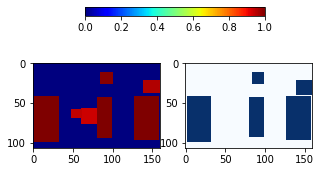

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(5., 2.5))
idx = 2
im1 = axes[0].imshow(all_prediction_image_res_maps[idx].T, cmap='jet', interpolation='nearest', vmin=0., vmax=1.)
im2 = axes[1].imshow(all_ground_truth_image_res_maps[idx].T, cmap='Blues', interpolation='nearest', vmin=0., vmax=1.)

cax = fig.add_axes([0.27, 1., 0.5, 0.05])

fig.colorbar(im1, cax=cax, orientation='horizontal')
plt.show()

In [25]:
model_output[idx]['ori_shape']

(428, 640, 3)

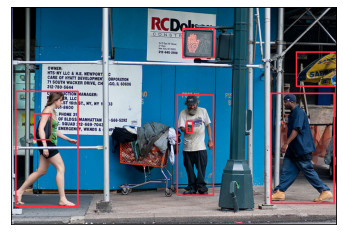

In [132]:
img_filename = model_output[idx]['ori_filename']
in_path = '../../data/coco/val2017/%s' % img_filename
# out_path = os.path.join("docs", "images", "winton_bb.png")
image = cv2.imread(in_path, cv2.IMREAD_COLOR)
gt_bboxes = model_output[idx]['gt_bboxes']
gt_bboxes = gt_bboxes.tolist()

for result in gt_bboxes:    
    bb.add(image, result[-4], result[-3], result[-2], result[-1], " ", "red")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.show()
plt.xticks([])
plt.yticks([])
plt.savefig(img_filename, format='pdf', bbox_inches='tight')

In [ ]:
image.shape

In [38]:
model_output[idx]

{'filename': 'data/coco/val2017/000000017627.jpg',
 'ori_filename': '000000017627.jpg',
 'ori_shape': (480, 640, 3),
 'img_shape': (800, 1067, 3),
 'pad_shape': (800, 1067, 3),
 'scale_factor': array([1.6671875, 1.6666666, 1.6671875, 1.6666666], dtype=float32),
 'flip': False,
 'flip_direction': None,
 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
  'std': array([58.395, 57.12 , 57.375], dtype=float32),
  'to_rgb': True},
 'batch_input_shape': (800, 1067),
 'query_embeds': array([[[ 0.6247662 , -0.18092917,  1.7672232 , ...,  0.72235423,
           0.16902709,  0.24923307],
         [ 0.5568712 , -0.15821096,  1.000512  , ...,  0.7063578 ,
           1.3579459 ,  0.17206945],
         [-1.0089644 ,  0.10223629,  1.2970828 , ..., -0.8157039 ,
           0.50500166,  0.83211255],
         ...,
         [-0.53624004, -0.02655528,  1.6161553 , ...,  0.15712875,
          -0.14253773,  0.8035924 ],
         [ 0.91062003, -0.26576838,  1.2344563 , ...,  1.389806

In [97]:
x1 = np.random.randn(3, 3)
x2 = np.random.randn(3, 3)

x = np.stack([x1, x2])
x

array([[[-0.82245459, -0.26512939, -1.33264342],
        [-1.3812042 ,  0.05328093, -1.02657106],
        [ 0.09080872, -1.47452595, -0.00357537]],

       [[-0.42856302,  1.08503956,  0.56104039],
        [-0.71502965, -0.71543484,  0.52324718],
        [ 0.71353536, -0.70421447,  0.25484503]]])

In [98]:
x = np.max(x, axis=0)

In [99]:
x

array([[-0.42856302,  1.08503956,  0.56104039],
       [-0.71502965,  0.05328093,  0.52324718],
       [ 0.71353536, -0.70421447,  0.25484503]])

In [100]:
x[0:10000, 0:1] = 0

In [101]:
x

array([[ 0.        ,  1.08503956,  0.56104039],
       [ 0.        ,  0.05328093,  0.52324718],
       [ 0.        , -0.70421447,  0.25484503]])

In [149]:
x = np.array([1, 2, 2, 2, 3, 4, 5, 5])
x==2

array([False,  True,  True,  True, False, False, False, False])

In [26]:
# objectness_pred_map_original = np.load('../../objectness_pred_map_downsampled_000000397133.jpg.npy')
objectness_pred_map_downsampled = np.load('../../objectness_pred_map_downsampled_000000252219.jpg.npy')

In [27]:
model_output[2]

{'filename': 'data/coco/val2017/000000252219.jpg',
 'ori_filename': '000000252219.jpg',
 'ori_shape': (428, 640, 3),
 'img_shape': (800, 1196, 3),
 'pad_shape': (800, 1196, 3),
 'scale_factor': array([1.86875  , 1.8691589, 1.86875  , 1.8691589], dtype=float32),
 'flip': False,
 'flip_direction': None,
 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
  'std': array([58.395, 57.12 , 57.375], dtype=float32),
  'to_rgb': True},
 'batch_input_shape': (800, 1196),
 'query_embeds': array([[[ 0.65080947, -0.6673976 ,  1.1768641 , ...,  0.9315562 ,
           0.11951109,  0.84103715],
         [ 0.52740186, -0.8002051 ,  1.1142912 , ...,  0.33306372,
          -0.49820882,  0.1688671 ],
         [-1.1621037 , -0.1926478 ,  1.4789821 , ..., -0.52743423,
           0.41348472,  0.9505622 ],
         ...,
         [-0.17604233, -0.40504813,  0.40685198, ...,  0.16665898,
          -0.6051192 ,  0.5944196 ],
         [ 0.05656814,  1.2721413 ,  1.916542  , ...,  0.694842

In [28]:
objectness_pred_map_downsampled.shape

(160, 107)

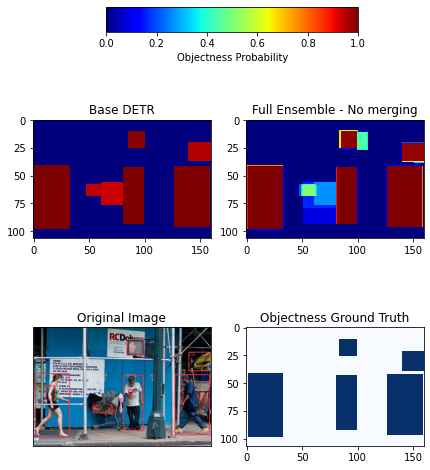

In [147]:
# fig, axes = plt.subplots(1, 3, figsize=(5., 2.5))
fig, axes = plt.subplots(2, 2, figsize=(7, 7), )
idx = 2
im0 = axes[0][0].imshow(all_prediction_image_res_maps[idx].T, cmap='jet', interpolation='nearest', vmin=0., vmax=1.)
im1 = axes[0][1].imshow(objectness_pred_map_downsampled.T, cmap='jet', interpolation='nearest', vmin=0., vmax=1.)
im2 = axes[1][1].imshow(all_ground_truth_image_res_maps[idx].T, cmap='Blues', interpolation='nearest', vmin=0., vmax=1.)
im3 = axes[1][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

axes[0][0].set_title('Base DETR')
axes[0][1].set_title('Full Ensemble - No merging')
axes[1][0].set_title('Original Image')
axes[1][0].set_xticks([])
axes[1][0].set_yticks([])
axes[1][1].set_title('Objectness Ground Truth')
cax = fig.add_axes([0.27, 1., 0.5, 0.05])

cbar = fig.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label("Objectness Probability")
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.savefig('objectness_map_full_ensemble_no_merging.pdf', format='pdf', bbox_inches='tight')

In [65]:
(objectness_pred_map_downsampled.reshape(-1, )>0.5).astype(int).mean()

0.30899532710280375